In [3]:
import copy

import brian2
import numpy as np
import matplotlib.pyplot as plt


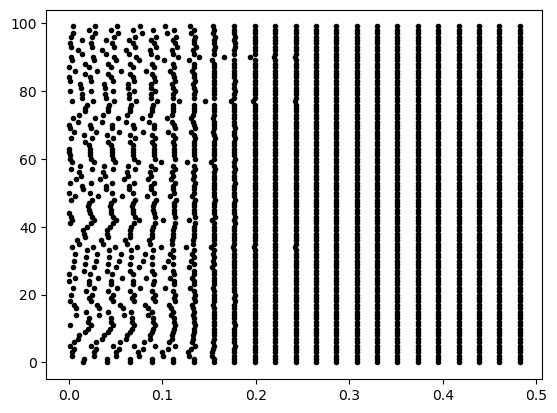

In [4]:


P = {'c_m': 1 * brian2.uF / brian2.cm ** 2,
     'g_L': 0.1 * brian2.mS / brian2.cm ** 2,
     'e_L': -65 * brian2.mV,
     'g_na': 35 * brian2.mS / brian2.cm ** 2,
     'e_na': 55 * brian2.mV,
     'phi': 5,
     'g_k': 9 * brian2.mS / brian2.cm ** 2,
     'e_k': -90 * brian2.mV,
     'g_syn': 0.1 * brian2.mS / brian2.cm ** 2,
     'e_syn': -75 * brian2.mV,
     'theta_syn': 0 * brian2.mV,
     'alpha': 12 / brian2.ms,
     'beta': 0.1 / brian2.ms,
     'n': 100,
     'dt': 0.05 * brian2.ms,
     'run_t': 0.5 * brian2.second,
     'p': 1.0,
     'i_app': 1.2 * brian2.uA / brian2.cm ** 2,
     'thresh': -52 * brian2.mV}


def alpha_h(v):
    return 0.07 * np.exp(-(v / brian2.mV + 58) / 20)


def beta_h(v):
    return 1 / (np.exp(-0.1 * (v / brian2.mV + 28)) + 1)


def alpha_n(v):
    return -0.01 * (v / brian2.mV + 34) / (np.exp(-0.1 * 
                                                  (v / brian2.mV + 34)) - 1)


def beta_n(v):
    return 0.125 * np.exp(-(v / brian2.mV + 44) / 80)


def f(v_pre):
    return 1 / (1 + np.exp(-(v_pre - P['theta_syn']) / brian2.mV / 2))


def generate_connectivity(n, p):
    n_cells = n * n
    adj = np.zeros(n_cells)
    n_conns = n_cells * p
    np.testing.assert_almost_equal(n_conns, int(n_conns))
    adj[:int(n_conns)] = 1
    np.random.shuffle(adj)
    return adj.reshape((n, n))

    
CONN = generate_connectivity(P['n'], P['p'])


def alpha_m(v):
    return -0.1 * (v / brian2.mV + 35) / (np.exp(-0.1 * 
                                                 (v / brian2.mV + 35)) - 1)


def beta_m(v):
    return 4 * np.exp(-(v / brian2.mV + 60) / 18)


def m_inf(v):
    return alpha_m(v) / (alpha_m(v) + beta_m(v))


def multiply_by_dt(x):
    new_x = copy.deepcopy(x)
    for i in range(len(new_x)):
        new_x[i] = new_x[i] * P['dt']
    return new_x


def add_k(state, k, divider):
    new_state = copy.deepcopy(state)
    for i in range(len(new_state)):
        new_state[i] = new_state[i] + k[i] / divider
    return new_state


def rk4(state):
    
    k1 = multiply_by_dt(system_dot(state))
    k2 = multiply_by_dt(system_dot(add_k(state, k1, 2)))
    k3 = multiply_by_dt(system_dot(add_k(state, k2, 2)))
    k4 = multiply_by_dt(system_dot(add_k(state, k3, 1)))

    new_state = add_k(state, add_k(add_k(add_k(k1, k2, 0.5), k3, 0.5), k4, 1),
                      6)
    return new_state


def system_dot(state):

    v, h, n, s = state

    i_na = P['g_na'] * m_inf(v) ** 3 * h * (v - P['e_na'])
    i_k = P['g_k'] * n ** 4 * (v - P['e_k'])
    i_L = P['g_L'] * (v - P['e_L'])
    i_syn = P['g_syn'] * s.dot(CONN) * (v - P['e_syn'])

    v_dot = (-i_na - i_k - i_L - i_syn + P['i_app']) / P['c_m']
    h_dot = P['phi'] * (alpha_h(v) * (1 - h) - beta_h(v) * h) * brian2.kHz
    n_dot = P['phi'] * (alpha_n(v) * (1 - n) - beta_n(v) * n) * brian2.kHz
    s_dot = P['alpha'] * f(v) * (1 - s) - P['beta'] * s

    return [v_dot, h_dot, n_dot, s_dot]

    
def run():

    # Define initial state.
    v_init = -70 * brian2.mV + np.random.rand(P['n']) * (-50 * brian2.mV -
                                                         -70 * brian2.mV)
    h_init = alpha_h(v_init) / (beta_h(v_init) + alpha_h(v_init))
    n_init = alpha_n(v_init) / (beta_n(v_init) + alpha_n(v_init))
    s_init = P['alpha'] * f(v_init) / (P['beta'] + P['alpha'] * f(v_init))
    
    # Define time.
    t_plot = np.linspace(0, P['run_t'], int(P['run_t'] / P['dt']) + 1)
    n_t = len(t_plot)

    # Define containers.
    v = np.zeros((P['n'], n_t)) * brian2.mV
    h = np.zeros((P['n'], n_t))
    n = np.zeros((P['n'], n_t))
    s = np.zeros((P['n'], n_t))

    # Enter initial state.
    v[:, 0] = v_init
    h[:, 0] = h_init
    n[:, 0] = n_init
    s[:, 0] = s_init

    # Scale weights based on in-degree.
    m_syn = P['n'] * P['p']
    P['g_syn'] /= m_syn

    # Run simulation.
    for i_t in range(1, n_t):
        state = [v[:, i_t - 1], h[:, i_t - 1], n[:, i_t - 1], s[:, i_t - 1]]
        new_v, new_h, new_n, new_s = rk4(state)
        v[:, i_t] = new_v
        h[:, i_t] = new_h
        n[:, i_t] = new_n
        s[:, i_t] = new_s

    return {'t_plot': t_plot, 'v': v}


def plot_raster(results):
    for i, v_trace in enumerate(results['v']):
        spike_times = np.where(np.logical_and(v_trace[:-1] < P['thresh'],
                                              v_trace[1:] >= P['thresh']))[0]
        plt.plot(results['t_plot'][spike_times], [i] * len(spike_times), 'k.')
    plt.show()

if __name__ == '__main__':
    results = run()
    plot_raster(results)
